In [329]:
import numpy as np
import pandas as pd
from itertools import combinations 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
import os
from tqdm import tqdm
import time

# Import data

In [51]:
data_path = "data.dat"
data= []
with open(data_path, encoding="utf-8") as f:
        tab = f.readlines()

In [70]:
data_1 = np.array([],dtype=int)
for basket in tqdm(tab):
    tab_dat = np.array(basket.split(" \n")[0].split(" ")).astype(int)
    data_1 = np.concatenate((data_1,tab_dat,np.array([-1])))

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:14<00:00, 1342.23it/s]


In [74]:
for a in tqdm(tab):
    tab_dat = a.split(" \n")[0].split(" ")
    set_sample = set()
    for val in tab_dat:
        set_sample.add(int(val))
    data.append(set_sample)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 94614.04it/s]


In [86]:
b=100
c=100
for basket in data :
    b = max(max(basket),b)
    c = min(min(basket),c)
n_values = b-c+1
print(b-c+1,"items")

1000 items


# Naive A-priori algorithm

In [335]:
from tqdm import tqdm

In [314]:
threshold_support = 0.01
threshold_confidence = 0.5

In [339]:
def get_candidates_singletons(data):
    res = set()
    for basket in data:
        res = res.union(basket)
    return res


def get_candidates(frequent_rank_1,frequent_rank_k):
    res = []
    for itemset in frequent_rank_k:
        for item in frequent_rank_1:
            if (min(item)<min(itemset)):
                if (len(item.union(itemset))==len(itemset)+1):
                    res.append(item.union(itemset))
    return res

def get_frequent(data, candidate, support):
    count = np.zeros(len(candidate))
    for i,cand in enumerate(candidate):
        for basket in tqdm(data):
            if (cand.issubset(basket)):
                count[candidate.index(itemset)]+=1
    return [cand for (cand,a) in zip(candidate,count) if a>support]

In [340]:
get_frequent(data,candidates,threshold_support*len(data))

  0%|                                                                          | 254/300000 [00:44<14:38:57,  5.68it/s]


KeyboardInterrupt: 

In [325]:
freq =[]
length_last = 10000000
level = 0
print("Let's go")
while (length_last>0):
    level+=1
    time_init = time.time()
    if (level==1):
        pre_candidates = get_candidates_singletons(data)
        candidates = [{i} for i in pre_candidates]
    else:
        candidates = get_candidates(freq[0],freq[level-2])
    print("We have found", len(candidates),"candidates for "+str(level)+"-tons")
    freq.append(get_frequent(data,candidates,threshold_support*len(data)))
    print("We have found",len(freq[level-1]),"frequent "+str(level)+"-tons")
    print("This step has taken",round(time.time()-time_init,2),"s")
    length_last = len(freq[level-1])

Let's go
We have found 870  candidates for 1-tons
We have found 375 frequent 1-tons
This step has taken 26.63 s
We have found 70125  candidates for 2-tons


KeyboardInterrupt: 

# First item

## Parameters

In [291]:
threshold_support = 0.01
threshold_confidence = 0.5

In [273]:
class Frequent_Item:
    '''Composition of frequent :
    [info for singletons, info for doublons, info for tripletons (if needed),...]
    info for X = [info for first X, info for second X, ...]
    info for xth X = [set with value of X, set with observation of X] => intersection of sets to implement bigger sets'''
    def __init__(self,tab_data,threshold_per, number_values=n_values):
        self.data = tab_data
        self.threshold = threshold_per*len(tab_data)
        self.n_values = number_values
        self.frequent = []
        
    def init_singletons(self,return_val=False):
        if (len(self.frequent)>0):
            raise (Exception("Singletons already initialized"))
        else:
            count_value = np.zeros(n_values)
            set_presence = [set() for i in range(n_values)]
            for i,basket in enumerate(self.data):
                for item in list(basket):
                    count_value[item]+=1
                    set_presence[item].add(i)
            index_frequent_single = [i for i,a in enumerate(count_value) if a>self.threshold]
            freq_singl = []
            for item in index_frequent_single:
                freq_singl.append([set([item]),set_presence[item]])
            self.frequent.append(freq_singl)
            if return_val:
                return count_value, set_presence

    def _add_level(self, prev_level):
        '''if a frequent item is composed of k products {p_1,...,p_k},
        so {p_1,p_2,..,p_i-1,p_i+1,...,p_k} {p_2,p_3,...} are frequent and the comparison of their index is enough for
        the next level (absurde reasoning)'''
        new_item = []
        freq_level = []
        for info_last in self.frequent[prev_level-1]:
            value_last, observation_last = info_last[0],info_last[1]
            min_last,max_last = min(value_last),max(value_last)
            ind = 0
            value_first, observation_first = self.frequent[prev_level-1][ind][0], self.frequent[prev_level-1][ind][1]
            first_val,max_first = min(value_first),max(value_first)
            while (min_last>first_val):
                if ((max_last>max_first)&(len(value_first.union(value_last))==prev_level+1)):
                    if (len(observation_first.intersection(observation_last))>self.threshold):
                        freq_level.append([value_first.union(value_last),observation_first.intersection(observation_last)])
                ind+=1
                value_first, observation_first = self.frequent[prev_level-1][ind][0],self.frequent[prev_level-1][ind][1]
                first_val,max_first = min(value_first),max(value_first)
        return freq_level            
            
    def _add_level_singl(self, prev_level):
        '''if a frequent item is composed of k products {p_1,...,p_k},
        so {p_1,p_2,..,p_i-1,p_i+1,...,p_k} {p_2,p_3,...} are frequent and the comparison of their index is enough for
        the next level (absurde reasoning)'''
        new_item = []
        freq_level = []
        for info_last in self.frequent[prev_level-1]:
            value_last, observation_last = info_last[0],info_last[1]
            min_last = min(value_last)
            ind = 0
            value_first, observation_first = self.frequent[0][ind][0], self.frequent[0][ind][1]
            first_val = min(value_first)
            while (min_last>first_val):
                if (len(observation_first.intersection(observation_last))>self.threshold):
                    freq_level.append([value_first.union(value_last),observation_first.intersection(observation_last)])
                ind+=1
                value_first, observation_first = self.frequent[prev_level-1][ind][0],self.frequent[prev_level-1][ind][1]
                first_val,max_first = min(value_first),max(value_first)
        return freq_level

    def init_multipletons(self, return_val=False):
        if (len(self.frequent)==0):
            raise (Exception("Singletons not initialized"))
        elif (len(self.frequent)>1):
            raise (Exception("Multipletons already initialized"))
        else:
            length_last = len(self.frequent[0])
            level = 1
            print("Let's go")
            while (length_last>0):
                if (level>1):
                    print(level, time.time()-time_init)
                    self.frequent.append(new_level)
                time_init = time.time()
                new_level = self._add_level(level)
                length_last = len(new_level)
                level+=1

In [280]:
FI = Frequent_Item(data,threshold_support)

NameError: name 'suport' is not defined

In [278]:
time_init = time.time()
FI.init_singletons()
print("This step has taken",round(time.time()-time_init,2),"s")

In [272]:
FI.init_multipletons()  #_add_level_singletons

Let's go
2 10.294444799423218
3 0.0


In [279]:
time_init = time.time()
FI.init_multipletons() #_add_level
print("This step has taken",round(time.time()-time_init,2),"s")

Let's go
2 10.756057739257812
3 0.0


In [282]:
print("Frequent items :",np.sum([len(a) for a in FI.frequent]))

Frequent items : 385


In [268]:
for i,a in enumerate(FI.frequent):
    print(len(a),"frequent item of",i+1,"products")

375 frequent item of 1 products
9 frequent item of 2 products
1 frequent item of 3 products


# Generating rules

In [ ]:
def rule_fun(data,Frequent_Item, position, c=threshold_confidence, n_val=n_values):
    count = np.zeros(n_val)
    support = len(position)
    for basket in position:
        for item in data[basket]:
            count[item]+=1
    return [[Frequent_Item,i] for i,a in enumerate(count) if (a>c*support)&(i not in Frequent_Item)]

In [ ]:
res=[]
for level in FI.frequent:
    for item in level:
        products = list(item[0])
        positions = list(item[1])
        rules = rule_fun(data,products,positions)
        for rule in rules :
            print(rule[0],"->",rule[1])

# Trash

In [250]:
FI.frequent[2][0][0],FI.frequent[2][1][0]

({39, 704, 825}, {39, 704, 825})

In [225]:
F2 = Frequent_Item(data, threshold_frequent)

In [226]:
F2.threshold

3000.0

In [227]:
count, pres = F2.init_singletons(return_val=True)

In [231]:
len(np.where(count>threshold_frequent)[0])

870

In [186]:
[a for i,a in count_value if a>self.threshold]

list

In [205]:
(FI.frequent[0][869][1])

{648,
 791,
 2986,
 4275,
 4279,
 5845,
 5875,
 6708,
 7462,
 7668,
 7975,
 8342,
 8412,
 8437,
 8835,
 8920,
 9554,
 9668,
 10747,
 10877,
 11449,
 11742,
 12673,
 12849,
 12856,
 12949,
 13410,
 13901,
 14292,
 14499,
 14830,
 14860,
 15257,
 15391,
 16906,
 17297,
 17563,
 17859,
 18106,
 18597,
 18665,
 18961,
 19094,
 19319,
 21632,
 21986,
 22031,
 22895,
 23682,
 24001,
 24201,
 24535,
 24675,
 24748,
 25531,
 25602,
 26332,
 26412,
 26792,
 27631,
 27790,
 28559,
 29851,
 31058,
 31301,
 31630,
 32300,
 32414,
 32627,
 33792,
 34323,
 34452,
 34583,
 34766,
 35038,
 36035,
 36221,
 36361,
 37404,
 37514,
 38723,
 38939,
 40285,
 41492,
 42449,
 43262,
 44443,
 44768,
 44809,
 45366,
 46181,
 46510,
 47523,
 48642,
 48703,
 49477,
 50039,
 50610,
 51117,
 51372,
 51573,
 52038,
 52348,
 52591,
 53000,
 53448,
 53779,
 54515,
 54970,
 55355,
 55753,
 56206,
 57163,
 58425,
 59708,
 59972,
 60135,
 60203,
 60616,
 60648,
 60988,
 61516,
 61991,
 62473,
 64233,
 64369,
 64813,
 652

In [206]:
len(FI.frequent[0])

870

In [150]:
min(set([1,6,7]))

1

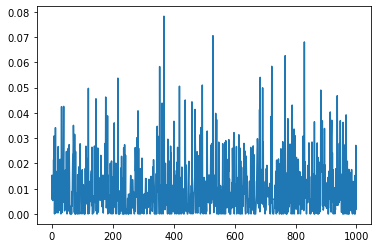

In [43]:

plt.plot(np.arange(1000),frequency_value)

In [223]:
(FI.threshold)

3000.0

In [247]:
len(FI.frequent[0])

375

In [221]:
for a in FI.frequent[0]:
    print(len(a[1]))

1782
4605
2019
1593
4182
3282
6447
2991
9270
4053
1575
10245
105
591
1374
450
5049
2439
363
120
7998
1191
384
573
4185
1581
6495
4362
513
4998
12744
4380
168
5952
1584
3747
7206
12774
1371
4059
357
5163
2709
5184
1629
525
7416
411
4836
5949
1605
7785
5877
342
8229
3990
936
330
957
2664
948
4803
7110
7233
10521
8556
6537
174
9453
7413
2478
810
2022
543
4665
687
909
633
5625
348
8331
3603
2523
2925
4398
1458
5247
987
327
981
3474
3300
2820
5403
3513
8040
1182
2448
5325
6579
2193
2748
14919
51
3243
84
882
3861
3225
1476
1575
4641
5133
981
7923
246
2121
144
771
2013
8061
1380
1362
4251
1515
13677
339
4149
1230
7833
201
297
4341
2091
1716
3420
2652
1626
2961
6960
4350
3768
2232
858
1038
1875
4614
105
3609
3291
1989
3240
1737
8373
1746
13887
1962
711
1272
3705
852
11649
4587
1044
2277
1950
117
1593
333
6012
2775
1551
6288
3690
4383
327
3087
168
2583
6522
10815
816
3642
4449
1254
6027
2334
1566
5679
2343
1575
16125
951
2151
378
2757
1113
1974
5454
354
6843
864
1326
4248
7854
294
8226
4197
235